**Trial_1** : CNN architecture transformed into a **Multi-Scale Convolutional Neural Network (MSCNN)** using *parallel convolution layers* with different kernel sizes.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Concatenate, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# load & Split data

In [3]:
# Load feature and target data
features = pd.read_csv(r"D:\JN\data set\created dataset\ECG PCG feature(128+128=256).csv", header=None, skiprows=[0])
targets = pd.read_csv(r'D:\JN\data set\data from web\Reference_aug.csv', header=None)

print(features.shape)
print(targets.shape)

# Extract target column
y = targets.iloc[:, -1]  # Selecting the last column
X = features  # All feature columns

# Using .apply() method
y = y.apply(lambda x: max(x, 0))

# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

(1975, 256)
(1975, 2)


In [4]:
# Standardize features
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Reshape data for Conv1D input
Xtrain_reshaped = Xtrain_scaled.reshape((Xtrain_scaled.shape[0], Xtrain_scaled.shape[1], 1))
Xtest_reshaped = Xtest_scaled.reshape((Xtest_scaled.shape[0], Xtest_scaled.shape[1], 1))

# Multi-Scale Convolutional Neural Network (MSCNN)

In [5]:
input_layer = Input(shape=(256, 1))

# Multi-scale convolution block
conv3 = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(input_layer)
conv5 = Conv1D(filters=16, kernel_size=5, padding='same', activation='relu')(input_layer)
conv7 = Conv1D(filters=16, kernel_size=7, padding='same', activation='relu')(input_layer)

# Merge multi-scale features
merged = Concatenate(axis=-1)([conv3, conv5, conv7])
merged = BatchNormalization()(merged)
merged = Dropout(0.5)(merged)

# Additional convolution + dropout layers
conv = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(merged)
conv = BatchNormalization()(conv)
conv = Dropout(0.5)(conv)

conv = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(conv)

# Fully connected layers
flattened = Flatten()(conv)
dense = Dense(128, activation='relu')(flattened)
dense = Dense(128, activation='relu')(dense)
dense = Dense(128, activation='relu')(dense)
dense = Dense(128, activation='relu')(dense)
output = Dense(1, activation='sigmoid')(dense)  # For binary classification

# Create and compile model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
# Train model
history = model.fit(Xtrain_reshaped, Ytrain, epochs=60, batch_size=32, validation_split=0.2)

Epoch 1/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.5393 - loss: 0.7055 - val_accuracy: 0.6108 - val_loss: 0.6764
Epoch 2/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6238 - loss: 0.6510 - val_accuracy: 0.6487 - val_loss: 0.6659
Epoch 3/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6495 - loss: 0.6151 - val_accuracy: 0.6487 - val_loss: 0.6555
Epoch 4/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6932 - loss: 0.5861 - val_accuracy: 0.6044 - val_loss: 0.6505
Epoch 5/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7149 - loss: 0.5479 - val_accuracy: 0.6994 - val_loss: 0.6086
Epoch 6/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7547 - loss: 0.5006 - val_accuracy: 0.6962 - val_loss: 0.6003
Epoch 7/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7512 - loss: 0.4976 - val_accuracy: 0.6266 - val_loss: 0.7062
Epoch 8/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7582 - loss: 0.5118 - val_accuracy: 0.6804 - v

In [7]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(Xtest_reshaped, Ytest)
print(f"Test Accuracy: {accuracy:.2%}")
print(f"Test Loss: {loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6937 - loss: 2.1317
Test Accuracy: 70.38%
Test Loss: 2.0569


In [8]:
Ypred = model.predict(Xtest_reshaped)
Ypred_classes = (Ypred > 0.5).astype(int)
Ypred_classes_flat = Ypred_classes.flatten()

# Print classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(Ytest, Ypred_classes_flat)) # Use Ytest directly

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.76      0.71       190
           1       0.75      0.65      0.69       205

    accuracy                           0.70       395
   macro avg       0.71      0.71      0.70       395
weighted avg       0.71      0.70      0.70       395



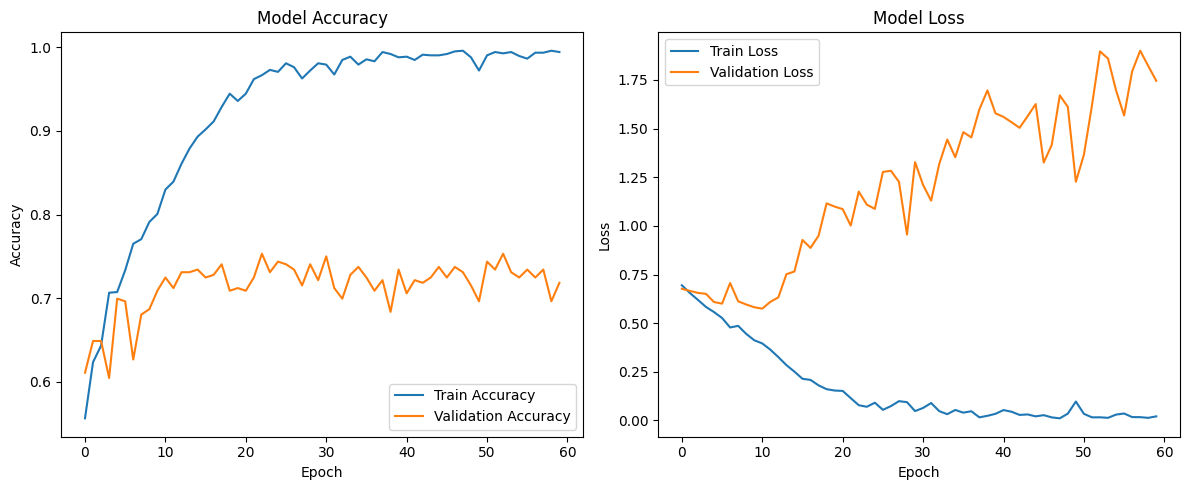

In [9]:
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


ROC AUC: 0.7776


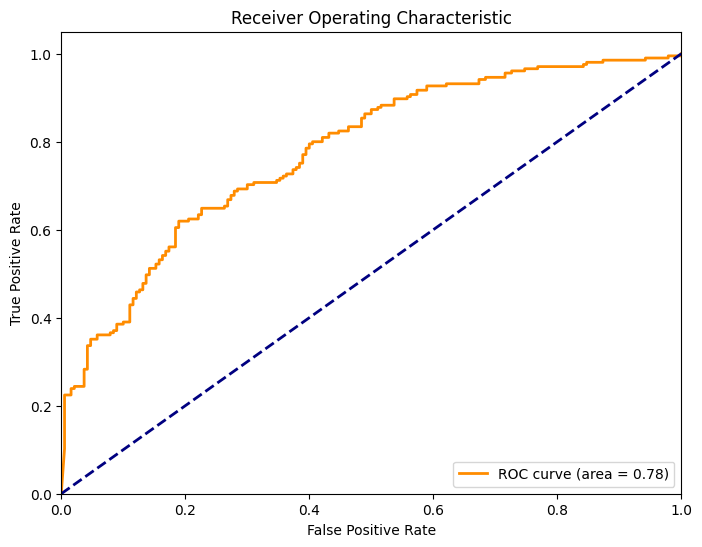

In [10]:
roc_auc = roc_auc_score(Ytest, Ypred[:, 0])
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot ROC curve
# Use Ytest for true labels and Ypred[:, 0] for predicted probabilities of the positive class
fpr, tpr, thresholds = roc_curve(Ytest, Ypred[:, 0])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

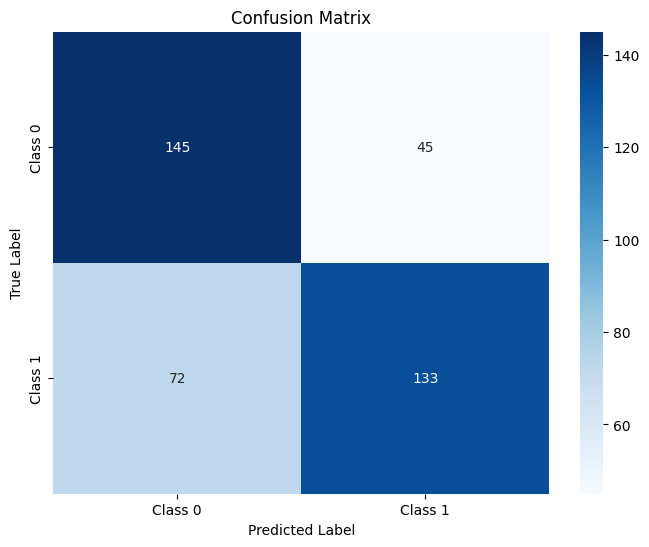

In [11]:
cm = confusion_matrix(Ytest, Ypred_classes_flat)
plt.figure(figsize=(8, 6))
class_labels = ['Class 0', 'Class 1'] # Or provide your actual class names if available

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()